In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune

from utils import read_pfm
from midas.model_loader import load_model
from run import run

%load_ext autoreload
%autoreload 2

/home/m.tang/miniconda3/envs/midas-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Structure

In [10]:
device = torch.device("cpu")
model = load_model(device, "weights/dpt_swin2_large_384.pt", "dpt_swin2_large_384", False, None, False)[0]
print(model)

/home/m.tang/miniconda3/envs/midas-py310/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642969563/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Model loaded, number of parameters = 213M
DPTDepthModel(
  (pretrained): Module(
    (model): SwinTransformerV2(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              (attn): WindowAttention(
                (cpb_mlp): Sequential(
                  (0): Linear(in_features=2, out_features=512, bias=True)
                  (1): ReLU(inplace=True)
                  (2): Linear(in_features=512, out_features=6, bias=False)
                )
                (qkv): Linear(in_features=192, out_features=576, bias=False)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=192, out_features=192, bias=True)
                (proj_drop): Dropout(p

## Pruning

In [39]:
device = torch.device("cpu")

amounts = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# pruning_type = 'local'
# pruning_type = 'global'
# pruning_type = 'scratch_local'
pruning_type = 'scratch_global'

In [40]:
def prune_model(model, amt, type, outpath):
    if type == "local":
        # Prune the weights
        for layers in model.pretrained.model.layers:
            for block in layers.blocks:
                # Prune Linear of SwinTransformerBlock
                prune.l1_unstructured(block.attn.cpb_mlp[0], 'weight', amount=amt)
                prune.l1_unstructured(block.attn.cpb_mlp[2], 'weight', amount=amt)
                prune.l1_unstructured(block.attn.qkv, 'weight', amount=amt)
                prune.l1_unstructured(block.attn.proj, 'weight', amount=amt)
                prune.l1_unstructured(block.mlp.fc1, 'weight', amount=amt)
                prune.l1_unstructured(block.mlp.fc2, 'weight', amount=amt)

        # Remove pruning renaming of parameters
        for layers in model.pretrained.model.layers:
            for block in layers.blocks:
                prune.remove(block.attn.cpb_mlp[0], 'weight')
                prune.remove(block.attn.cpb_mlp[2], 'weight')
                prune.remove(block.attn.qkv, 'weight')
                prune.remove(block.attn.proj, 'weight')
                prune.remove(block.mlp.fc1, 'weight')
                prune.remove(block.mlp.fc2, 'weight')
    elif type == "global":
        parameters_to_prune = []
        for layers in model.pretrained.model.layers:
            for block in layers.blocks:
                parameters_to_prune.extend([
                    (block.attn.cpb_mlp[0], 'weight'),
                    (block.attn.cpb_mlp[2], 'weight'),
                    (block.attn.qkv, 'weight'),
                    (block.attn.proj, 'weight'),
                    (block.mlp.fc1, 'weight'),
                    (block.mlp.fc2, 'weight')
                ])
        prune.global_unstructured(
            tuple(parameters_to_prune), 
            pruning_method=prune.L1Unstructured,
            amount=amt
        )

        # Remove pruning renaming of parameters
        for layers in model.pretrained.model.layers:
            for block in layers.blocks:
                prune.remove(block.attn.cpb_mlp[0], 'weight')
                prune.remove(block.attn.cpb_mlp[2], 'weight')
                prune.remove(block.attn.qkv, 'weight')
                prune.remove(block.attn.proj, 'weight')
                prune.remove(block.mlp.fc1, 'weight')
                prune.remove(block.mlp.fc2, 'weight')
    elif type == "scratch_local":
        prune.l1_unstructured(model.scratch.layer1_rn, 'weight', amount=amt)
        prune.l1_unstructured(model.scratch.layer2_rn, 'weight', amount=amt)
        prune.l1_unstructured(model.scratch.layer3_rn, 'weight', amount=amt)
        prune.l1_unstructured(model.scratch.layer4_rn, 'weight', amount=amt)

        prune.remove(model.scratch.layer1_rn, 'weight')
        prune.remove(model.scratch.layer2_rn, 'weight')
        prune.remove(model.scratch.layer3_rn, 'weight')
        prune.remove(model.scratch.layer4_rn, 'weight')
    elif type == "scratch_global":
        parameters_to_prune = []
        parameters_to_prune.extend([
                    (model.scratch.layer1_rn, 'weight'),
                    (model.scratch.layer2_rn, 'weight'),
                    (model.scratch.layer3_rn, 'weight'),
                    (model.scratch.layer4_rn, 'weight'),
                    ])
        prune.global_unstructured(
            tuple(parameters_to_prune), 
            pruning_method=prune.L1Unstructured,
            amount=amt
        )

        prune.remove(model.scratch.layer1_rn, 'weight')
        prune.remove(model.scratch.layer2_rn, 'weight')
        prune.remove(model.scratch.layer3_rn, 'weight')
        prune.remove(model.scratch.layer4_rn, 'weight')
    else:
        raise ValueError("Invalid 'type'. Choose 'local', 'global', 'scratch_local', or 'scratch_global'")
    
    # Save pruned weights
    torch.save(model.state_dict(), outpath)
  
    return

In [41]:
# Prune model
for pruning_amt in amounts:
    pruned_weights_path = "weights/pruned/dpt_swin2_large_384_{}_{}.pt".format(pruning_type, pruning_amt)
    if not os.path.exists(pruned_weights_path):
        model = load_model(device, "weights/dpt_swin2_large_384.pt", "dpt_swin2_large_384", False, None, False)[0]
        prune_model(model, pruning_amt, pruning_type, pruned_weights_path)
    print("Pruned model by {} amount with {} pruning".format(pruning_amt, pruning_type))
    

Model loaded, number of parameters = 213M
Pruned model by 0.1 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.15 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.2 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.25 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.3 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.4 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.5 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.6 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.7 amount with scratch_global pruning
Model loaded, number of parameters = 213M
Pruned model by 0.8 amount with scratch_global pruning
Model loaded, number of para

In [42]:
images_path = "/scratch/kevinand/courses/cs225b/project/datasets/nyu_v2/images"

# Run pruned models to generate depth images
for pruning_amt in amounts:
    midas_depth_path = "output/pruning_{}_{}/".format(pruning_type, pruning_amt)
    pruned_weights_path = "weights/pruned/dpt_swin2_large_384_{}_{}.pt".format(pruning_type, pruning_amt)
    if not os.path.exists(midas_depth_path):
        run(images_path, midas_depth_path, pruned_weights_path, 'dpt_swin2_large_384')
    print("Generated depth output from {} {} pruned model".format(pruning_amt, pruning_type))


Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:28,  6.94it/s]


Finished
Generated depth output from 0.1 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:30,  6.89it/s]


Finished
Generated depth output from 0.15 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:29,  6.91it/s]


Finished
Generated depth output from 0.2 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:29,  6.92it/s]


Finished
Generated depth output from 0.25 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:29,  6.93it/s]


Finished
Generated depth output from 0.3 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:29,  6.92it/s]


Finished
Generated depth output from 0.4 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:29,  6.91it/s]


Finished
Generated depth output from 0.5 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:28,  6.96it/s]


Finished
Generated depth output from 0.6 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:30,  6.89it/s]


Finished
Generated depth output from 0.7 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:31,  6.85it/s]


Finished
Generated depth output from 0.8 scratch_global pruned model
Initialize
Device: cuda
Model loaded, number of parameters = 213M
Start processing


1449it [03:31,  6.85it/s]

Finished
Generated depth output from 0.9 scratch_global pruned model


## Accuracy

In [43]:
def least_squares(midas_img_path, golden_depth_path):
    # Read images
    M = read_pfm(midas_img_path)
    G = pickle.load(open(golden_depth_path, 'rb'))

    # Extract images
    MM = M[0].flatten()  # For some reason returns a tuple
    GG = G.flatten()
    X = np.vstack((MM, np.ones(GG.shape))).T 	# Form x matrix
    Y = 1/GG	# Invert depth (paper operates in inverse depth space)
    B = np.linalg.inv(X.T @ X) @ X.T @ Y # compute least squares

    return B[0], B[1]


def nyu_accuracy(midas_img_path, golden_depth_path):
    scale, shift = least_squares(midas_img_path, golden_depth_path)
    
    midas_img = np.array(read_pfm(midas_img_path)[0])
    golden_img = pickle.load(open(golden_depth_path, 'rb'))

    midas_img = scale * midas_img + shift
    golden_img = 1 / golden_img

    max_cmp = np.maximum(np.divide(midas_img, golden_img), np.divide(golden_img, midas_img))
    error = np.sum(max_cmp > 1.25) / midas_img.size * 100
    
    return error
    

def evaluate(midas_output_dir, golden_dir):
    errors = np.zeros(1449)
    for midas_filename in tqdm(os.listdir(midas_output_dir)):
        if not midas_filename.endswith('.pfm'):
            continue
        midas_path = os.path.join(midas_output_dir, midas_filename)
        num = midas_filename.split('_')[0]
        if int(num) == 130: # image 130 in the depth dir is an RGB image, not a depth map
            continue
        golden_filename = [f for f in os.listdir(golden_dir) if f.startswith('{}_'.format(num))][0]
        golden_path = os.path.join(golden_dir, golden_filename)

        err = nyu_accuracy(midas_path, golden_path)
        errors[int(num)] = err

    # print(errors)
    errors = np.delete(errors, 130)
    
    min_i = np.argmin(errors)
    min_i = min_i + 1 if min_i >= 130 else min_i
    
    max_i = np.argmax(errors)
    max_i = max_i + 1 if max_i >= 130 else max_i
    
    errors = np.sort(errors)
    N = len(errors)

    # return {"min" : errors[0], 
    #         "quartile1" : errors[N//4], 
    #         "median" : errors[N//2], 
    #         "quartile3" : errors[3*N//4],
    #         "max" : errors[-1],
    #         "mean": np.mean(errors),
    #         "min_i": min_i,
    #         "max_i": max_i }
    
    print("Minimum error: {}% (Image {})".format(errors[0], min_i))
    print("Maximum error: {}% (Image {})".format(errors[-1], max_i))
    
    return {"data" : errors,
            "mean": np.mean(errors),
            "min_i": min_i,
            "max_i": max_i }
    

In [44]:
golden_depth_path = "/scratch/kevinand/courses/cs225b/project/datasets/nyu_v2/depths/"

# Original model
print("Evaluating depth outputs from original unpruned model")
data_dict = evaluate("output/orig/", golden_depth_path)
print("\n")

mean_errors = [data_dict["mean"]]
all_data = np.array(data_dict["data"])
    
# Evaluate results from pruned models
for pruning_amt in amounts:
    midas_depth_path = "output/pruning_{}_{}/".format(pruning_type, pruning_amt)

    print("Evaluating depth outputs from {} {} pruned model".format(pruning_amt, pruning_type))
    
    err_dict = evaluate(midas_depth_path, golden_depth_path)

    mean_errors.append(err_dict["mean"])
    all_data = np.vstack((all_data, err_dict["data"]))

    print("\n")


Evaluating depth outputs from original unpruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:12<00:00, 233.75it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.34342447916667% (Image 451)


Evaluating depth outputs from 0.1 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 252.36it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.32486979166667% (Image 451)


Evaluating depth outputs from 0.15 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 248.49it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.35677083333334% (Image 451)


Evaluating depth outputs from 0.2 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 250.90it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.384765625% (Image 451)


Evaluating depth outputs from 0.25 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 251.37it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.6240234375% (Image 451)


Evaluating depth outputs from 0.3 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 250.82it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.73795572916667% (Image 451)


Evaluating depth outputs from 0.4 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 248.00it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 68.87109375% (Image 451)


Evaluating depth outputs from 0.5 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 252.87it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 69.62467447916667% (Image 451)


Evaluating depth outputs from 0.6 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 250.74it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 70.13802083333334% (Image 451)


Evaluating depth outputs from 0.7 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 251.72it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 71.1142578125% (Image 451)


Evaluating depth outputs from 0.8 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:12<00:00, 238.97it/s]


Minimum error: 0.0% (Image 41)
Maximum error: 71.94661458333333% (Image 451)


Evaluating depth outputs from 0.9 scratch_global pruned model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:11<00:00, 250.00it/s]

Minimum error: 0.0% (Image 41)
Maximum error: 73.36328125% (Image 451)




Pruning amount 0: 4.966% error (0.000% from unpruned)
Pruning amount 0.1: 4.965% error (-0.001% from unpruned)
Pruning amount 0.15: 4.966% error (-0.000% from unpruned)
Pruning amount 0.2: 4.967% error (0.001% from unpruned)
Pruning amount 0.25: 4.967% error (0.001% from unpruned)
Pruning amount 0.3: 4.974% error (0.008% from unpruned)
Pruning amount 0.4: 4.979% error (0.013% from unpruned)
Pruning amount 0.5: 5.008% error (0.042% from unpruned)
Pruning amount 0.6: 5.038% error (0.072% from unpruned)
Pruning amount 0.7: 5.150% error (0.184% from unpruned)
Pruning amount 0.8: 5.363% error (0.397% from unpruned)
Pruning amount 0.9: 5.827% error (0.861% from unpruned)

Exact mean error values:
 [4.965908212117288, 4.965404419170119, 4.965518396423227, 4.96701493798918, 4.96668492101174, 4.973957658911717, 4.978628028602671, 5.008202090886855, 5.038024115518532, 5.149624706851404, 5.363400847433241, 5.826890134021063]


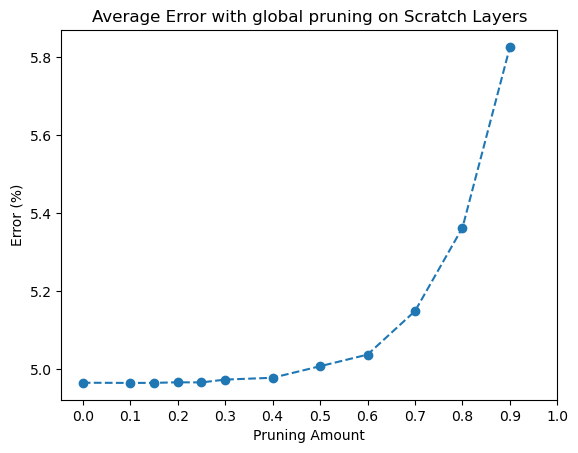

In [49]:
# Plot mean errors
x_vals = [0]
x_vals.extend(amounts)

for i in range(len(x_vals)):
    x = x_vals[i]
    err = mean_errors[i]
    print("Pruning amount {}: {:.3f}% error ({:.3f}% from unpruned)".format(x, err, err - mean_errors[0]))

print("\nExact mean error values:\n", mean_errors)

# what_pruned = "SwinTransformerBlocks"
what_pruned = "Scratch Layers"
# t = pruning_type
t = "global"

plt.plot(x_vals, mean_errors, '--o')
plt.xticks(np.linspace(0, 1, 11))
plt.title("Average Error with {} pruning on {}".format(t, what_pruned))
plt.xlabel("Pruning Amount")
plt.ylabel("Error (%)")
plt.show()

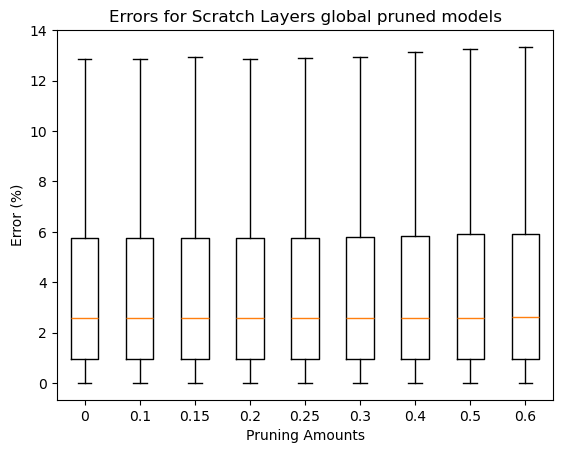

In [54]:
# Plot boxplot
fig, ax = plt.subplots()
ax.set_title("Errors for {} {} pruned models".format(what_pruned, t))

### Only plot up to 0.6
# ax.boxplot(all_data[:9].T, flierprops=dict(marker='o', markersize=3))
ax.boxplot(all_data[:9].T, showfliers=False) # Don't show outliers
# ax.boxplot(all_data[:9].T, whis=(0, 100)) # Set whiskers to end at min and max
ax.set_xticks([y + 1 for y in range(9)],
              labels=[str(x) for x in x_vals[:9]])

### Plot all data
# ax.boxplot(all_data.T, flierprops=dict(marker='o', markersize=3))
# ax.boxplot(all_data.T, showfliers=False) # Don't show outliers
# ax.set_xticks([y + 1 for y in range(len(all_data))],
              # labels=[str(x) for x in x_vals])


ax.set_xlabel("Pruning Amounts")
ax.set_ylabel("Error (%)")
plt.show()

### Errors per pruning type (also sent in Slack)

## Compressed Model Size

In [55]:
# Uncompressed size of pruned models won't change since pruning just sets values to 0
perform_compression = True

# Calculate compressed size of weights
if perform_compression:
    if not os.path.exists("weights/dpt_swin2_large_384.pt.gz"):
        !gzip -qf -k weights/dpt_swin2_large_384.pt
        !du -h weights/dpt_swin2_large_384.pt.gz

orig_size = os.path.getsize("weights/dpt_swin2_large_384.pt.gz")
print("Compressed size of original model: {:.2f} M".format(orig_size / (2**20)))

for pruning_amt in amounts:
    pruned_weights_path = "weights/pruned/dpt_swin2_large_384_{}_{}.pt".format(pruning_type, pruning_amt)
    pruned_weights_compressed_path = "{}.gz".format(pruned_weights_path)

    if perform_compression:
        if not os.path.exists(pruned_weights_compressed_path):
            !gzip -qf -k $pruned_weights_path
            !du -h $pruned_weights_compressed_path
    
    size = os.path.getsize(pruned_weights_compressed_path)
    print("Compressed size of model ({} pruning, {} amount): {:.2f} M, down {:.2f}%".format(
        pruning_type, 
        pruning_amt, 
        size / (2**20), 
        (orig_size - size) / orig_size * 100))

Compressed size of original model: 756.08 M
755M	weights/pruned/dpt_swin2_large_384_scratch_global_0.1.pt.gz
Compressed size of model (scratch_global pruning, 0.1 amount): 754.63 M, down 0.19%
754M	weights/pruned/dpt_swin2_large_384_scratch_global_0.15.pt.gz
Compressed size of model (scratch_global pruning, 0.15 amount): 753.76 M, down 0.31%
753M	weights/pruned/dpt_swin2_large_384_scratch_global_0.2.pt.gz
Compressed size of model (scratch_global pruning, 0.2 amount): 752.80 M, down 0.43%
752M	weights/pruned/dpt_swin2_large_384_scratch_global_0.25.pt.gz
Compressed size of model (scratch_global pruning, 0.25 amount): 751.82 M, down 0.56%
751M	weights/pruned/dpt_swin2_large_384_scratch_global_0.3.pt.gz
Compressed size of model (scratch_global pruning, 0.3 amount): 750.88 M, down 0.69%
749M	weights/pruned/dpt_swin2_large_384_scratch_global_0.4.pt.gz
Compressed size of model (scratch_global pruning, 0.4 amount): 748.88 M, down 0.95%
747M	weights/pruned/dpt_swin2_large_384_scratch_global_0.5

### Compression Outputs

## Display images

Original RGB image
409_office_kitchen_0001b-r-1315407263-252241-1100023247.ppm


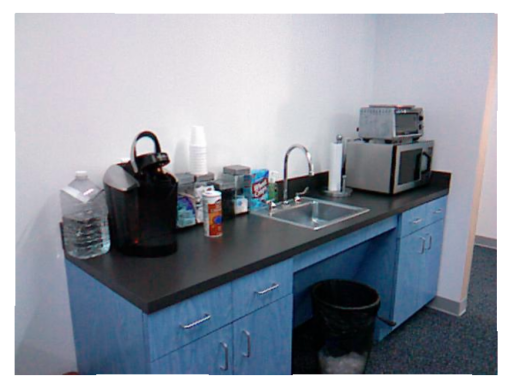

Golden depth image


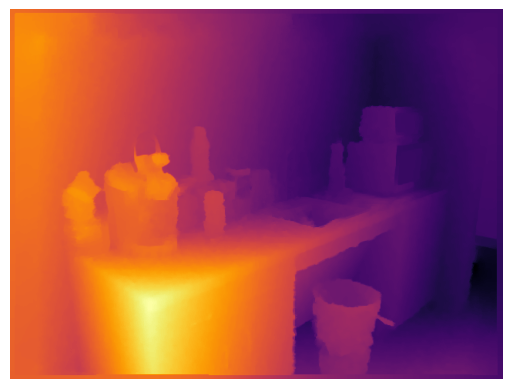

Unpruned MiDaS depth image


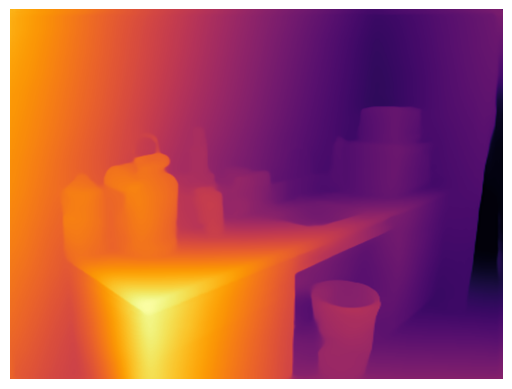

MiDaS depth image: global 0.1


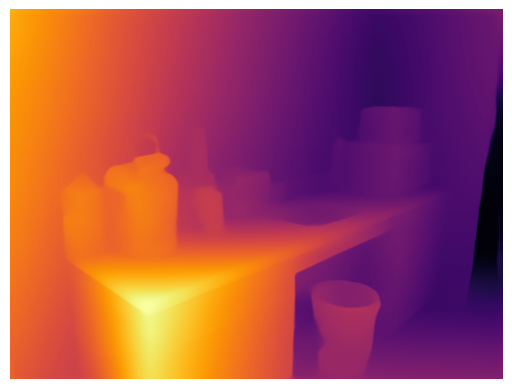

MiDaS depth image: global 0.15


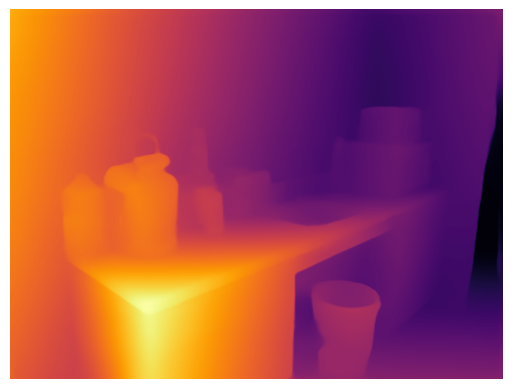

MiDaS depth image: global 0.2


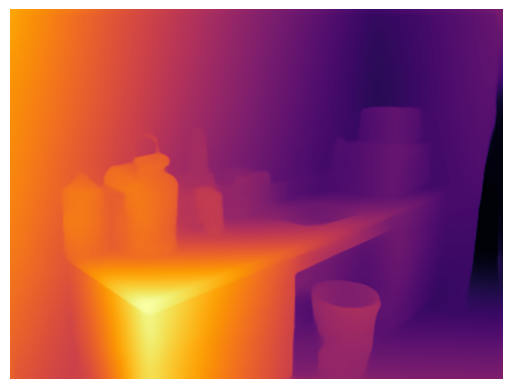

MiDaS depth image: global 0.25


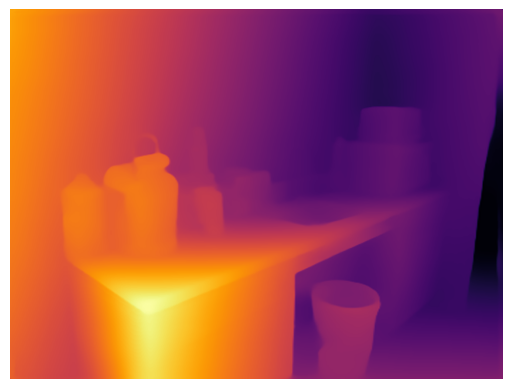

MiDaS depth image: global 0.3


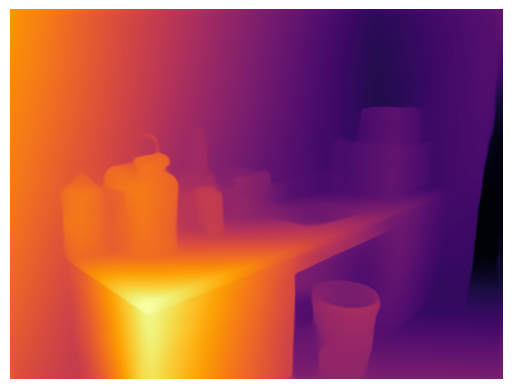

MiDaS depth image: global 0.4


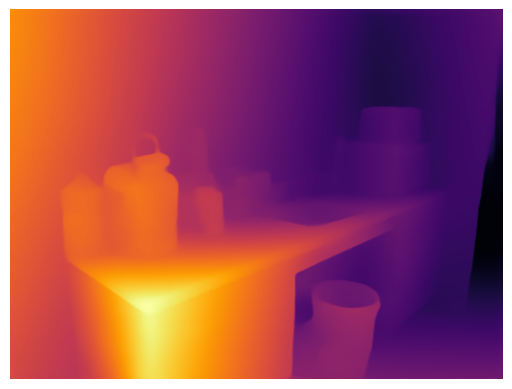

MiDaS depth image: global 0.5


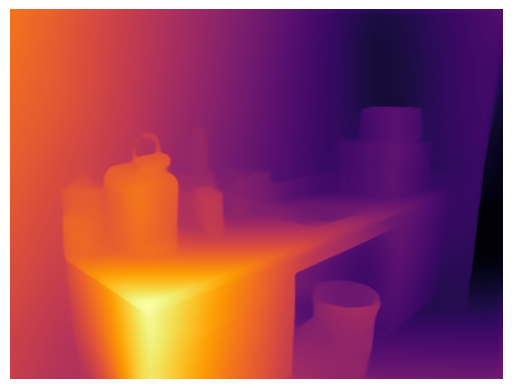

MiDaS depth image: global 0.6


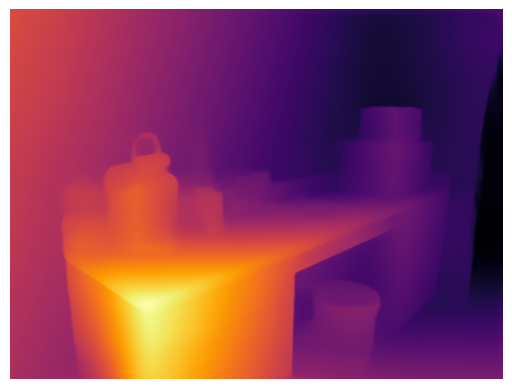

MiDaS depth image: global 0.7


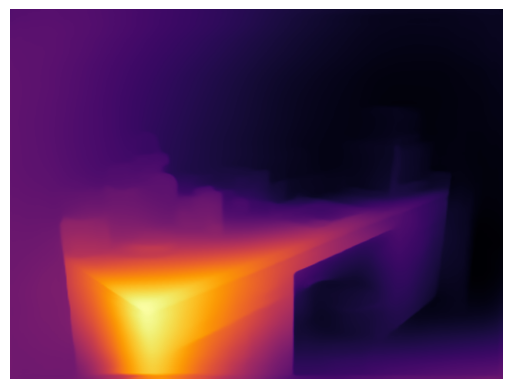

MiDaS depth image: global 0.8


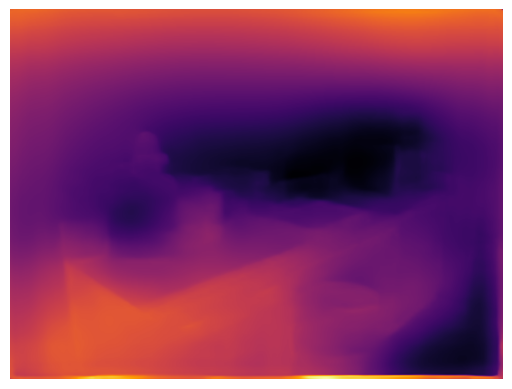

MiDaS depth image: global 0.9


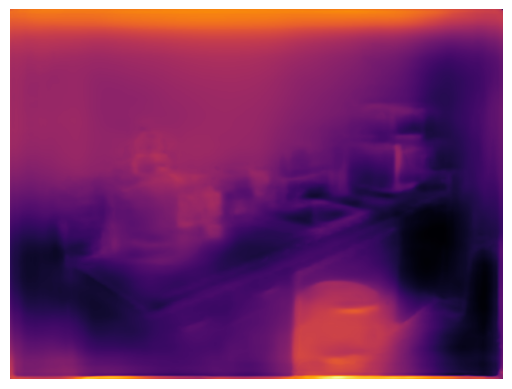

In [72]:
pruning_type = "global"
amounts = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
num = 409

print("Original RGB image")
img_dir = '/scratch/kevinand/courses/cs225b/project/datasets/nyu_v2/images/'
img_filename = [f for f in os.listdir(img_dir) if f.startswith('{}_'.format(num))][0]
img_path = os.path.join(img_dir, img_filename)
print(img_filename)
img = plt.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

print("Golden depth image")
golden_dir = '/scratch/kevinand/courses/cs225b/project/datasets/nyu_v2/depths/'
golden_filename = [f for f in os.listdir(golden_dir) if f.startswith('{}_'.format(num))][0]
golden_path = os.path.join(golden_dir, golden_filename)

G = pickle.load(open(golden_path, 'rb'))
plt.imshow(1/G, cmap='inferno')
plt.axis('off')
plt.show()

print("Unpruned MiDaS depth image")
unpruned_dir = "output/orig/"
unpruned_filename = [f for f in os.listdir(unpruned_dir) if f.startswith('{}_'.format(num)) and f.endswith('.png')][0]
unpruned_path = os.path.join(unpruned_dir, unpruned_filename)

U = plt.imread(unpruned_path)
plt.imshow(U)
plt.axis('off')
plt.show()

for amt in amounts:
    print("MiDaS depth image: {} {}".format(pruning_type, amt))
    midas_dir = "output/pruning_{}_{}/".format(pruning_type, amt)
    midas_filename = [f for f in os.listdir(midas_dir) if f.startswith('{}_'.format(num)) and f.endswith('.png')][0]
    midas_path = os.path.join(midas_dir, midas_filename)
    
    M = plt.imread(midas_path)
    plt.imshow(M)
    plt.axis('off')
    plt.show()

## Misc

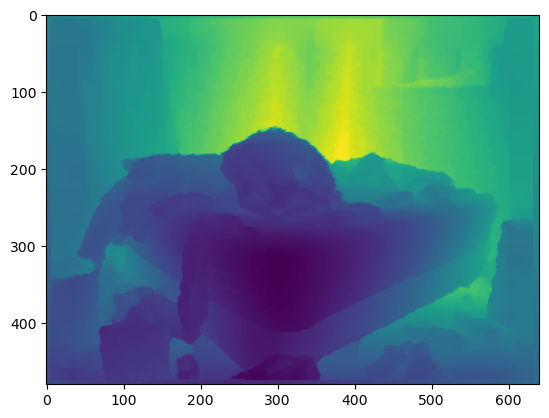

In [68]:
# Visualize depth images (image 130 is faulty, not a depth image)
G = pickle.load(open('/scratch/kevinand/courses/cs225b/project/datasets/nyu_v2/depths/59_bedroom_0013-d-1295837530-748344-3936537799.pk', 
                     'rb'))
GG = pickle.load(open('/scratch/kevinand/courses/cs225b/project/datasets/nyu_v2/depths/130_kitchen_0007-d-1295834922-709732-2051483861.pk', 
                      'rb'))
plt.imshow(G)
plt.show()

In [109]:
# Testing...
!gzip -qf -k weights/pruned/dpt_swin2_large_384_local_0.9.pt
!du -h weights/pruned/dpt_swin2_large_384_local_0.9.pt.gz

226M	weights/pruned/dpt_swin2_large_384_local_0.9.pt.gz
